In [211]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [212]:
import matplotlib.pyplot as plt
import os, shutil
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

from KAGGLE_NLP_with_disaster_tweets.model import base_model, utils, constants
from KAGGLE_NLP_with_disaster_tweets.data_preparation.utils import DataPipeline, BatchPipeline

os.environ["CUDA_VISIBLE_DEVICES"]="-1"

log_dir = './logs/hyperparameter_tuning_BaseModelOpt/'

 # clearing logging directory
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
else:
    os.makedirs(log_dir)

In [213]:
train_file_name = 'train.csv'
kaggle_test_file_name = 'test.csv'
sample_submission_file_name = 'sample_submission.csv'

max_vocabulary_size = 20000
glove_embedding_dim = 200

data_pipeline = DataPipeline(train_file_name, kaggle_test_file_name, sample_submission_file_name,
                             max_vocabulary_size=max_vocabulary_size,
                             output_sequence_length=30,
                             glove_embedding_dim=glove_embedding_dim,
                             glove_url=constants.glove_url['twitter.27B'])
dataset = data_pipeline.prepare_train_dataset(include_cols=["keyword", "location"], extract_extras=True)

Getting the file: ../data/sample_submission.csv
Getting the file: ../data/train.csv
Dataframe size before eliminating too short texts: 7613
Dataframe size after eliminating too short texts: 7529
         id keyword location  \
0         1                    
1         4                    
2         5                    
3         6                    
4         7                    
...     ...     ...      ...   
7608  10869                    
7609  10870                    
7610  10871                    
7611  10872                    
7612  10873                    

                                                   text  target  
0     our deeds are the reason of this earthquake ma...       1  
1                 forest fire near la ronge sask canada       1  
2     all residents asked to shelter in place are be...       1  
3     13  0 people receive wildfires evacuation orde...       1  
4     just got sent this photo from ruby alaska as s...       1  
...                     

In [214]:
dataframe = data_pipeline.dataframe
isTrueCount = dataframe["target"].where(dataframe["target"] == 1).count()
isFalseCount = dataframe["target"].where(dataframe["target"] == 0).count()
print(f"True instances: {isTrueCount} | {100 * isTrueCount / (isTrueCount + isFalseCount)}% of data")
print(f"False instances: {isFalseCount} | {100 * isFalseCount / (isTrueCount + isFalseCount)}% of data")

True instances: 3258 | 43.272678974631425% of data
False instances: 4271 | 56.727321025368575% of data


In [215]:
balanced_class_weights = utils.get_balanced_class_weights(dataframe)

In [216]:
from tensorboard.plugins.hparams import api as hp

epochs = 15
log_directory = "./logs/hyperparameter_tuning_BaseModel/"

# create a dict to keep the hyperparameters
hparams = {
    hp.HParam("optimizer", hp.Discrete(["adamw"])): "adamw",
    hp.HParam("batch_size", hp.Discrete([16, 32, 64])): 64,
    hp.HParam("learning_rate", hp.Discrete([1e-3, 1e-4])): 1e-4,
    hp.HParam("class_weights", hp.Discrete(["none", "balanced"])): "none",
    hp.HParam("dropout", hp.Discrete([0.1, 0.4])): 0.1
}
# easier to manage hyperparameters with this wrapper class
hyperparameter_manager = utils.HyperparameterManager(hparams=hparams)

In [217]:
model = base_model.BaseModel(
    vocabulary_size=data_pipeline.vocabulary_size,
    embedding_dim=data_pipeline.glove_embedding_dim,
    lstm_dims=[128, 64],
    hidden_dim=64,
    num_classes=2,
    epochs=epochs,
    batch_pipeline=BatchPipeline(dataset, hyperparameter_manager.batch_size),
    hparam_manager=hyperparameter_manager,
    embeddings_initializer=data_pipeline.build_embeddings_initializer())

Loading the file: glove.twitter.27B.200d.txt 

Found 1193514 word vectors 

Converted 12866 words, and missed 4707 words.
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, None, 200)         3514600   
                                                                 
 dropout_36 (Dropout)        (None, None, 200)         0         
                                                                 
 bidirectional_39 (Bidirecti  (None, None, 256)        336896    
 onal)                                                           
                                                                 
 bidirectional_40 (Bidirecti  (None, None, 128)        164352    
 onal)                                                           
                                                                 
 dense_36 (Dense)            (None, None, 64)          8256    

## Overfitting for sanity check

In [218]:
debugging_dataset = dataset.take(2).batch(2)
model.test_model(debugging_dataset, 20)

Epoch 1/20
1/1 [==============================] - 7s 7s/step - loss: 0.7378 - accuracy: 0.0000e+00 - val_loss: 0.7412 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 184ms/step - loss: 0.7325 - accuracy: 0.0000e+00 - val_loss: 0.7411 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 182ms/step - loss: 0.7344 - accuracy: 0.0000e+00 - val_loss: 0.7409 - val_accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 185ms/step - loss: 0.7464 - accuracy: 0.0000e+00 - val_loss: 0.7405 - val_accuracy: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 174ms/step - loss: 0.7464 - accuracy: 0.0000e+00 - val_loss: 0.7401 - val_accuracy: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 195ms/step - loss: 0.7387 - accuracy: 0.0000e+00 - val_loss: 0.7396 - val_accuracy: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 179ms/step - loss: 0.7353 - accuracy: 0.0000e+00 - val_loss: 0

## Train the dataset

In [219]:
accuracy, precision, recall, f1, predictions1 = model.fit_and_evaluate(class_weights=balanced_class_weights, log_directory=log_directory)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-Score: {f1}")

basemodel__lr=0.0001__batch_size=64__optimizer=adamw__class_weights=none__dropout=0.1 starting...
Epoch 1/15
70/70 [==============================] - 11s 110ms/step - loss: 0.6801 - accuracy: 0.5743 - val_loss: 0.6577 - val_accuracy: 0.6114
Epoch 2/15
70/70 [==============================] - 6s 84ms/step - loss: 0.5876 - accuracy: 0.7391 - val_loss: 0.5011 - val_accuracy: 0.7711
Epoch 3/15
70/70 [==============================] - 6s 85ms/step - loss: 0.4821 - accuracy: 0.7871 - val_loss: 0.4626 - val_accuracy: 0.7894
Epoch 4/15
70/70 [==============================] - 6s 85ms/step - loss: 0.4489 - accuracy: 0.8004 - val_loss: 0.4528 - val_accuracy: 0.7969
Epoch 5/15
70/70 [==============================] - 6s 89ms/step - loss: 0.4346 - accuracy: 0.8098 - val_loss: 0.4499 - val_accuracy: 0.7942
Epoch 6/15
70/70 [==============================] - 6s 91ms/step - loss: 0.4267 - accuracy: 0.8165 - val_loss: 0.4476 - val_accuracy: 0.7948
Epoch 7/15
70/70 [==============================] - 6s

## Visualize accuracy and loss

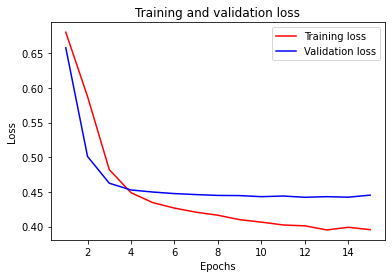

In [220]:
history_dict = model.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

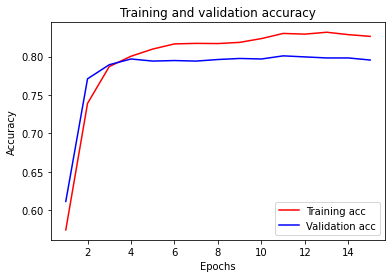

In [221]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [222]:
# model.save_model()
